# MS RCC Classification

Author: Olatomiwa Bifarin<br>
Department of Biochemistry and Molecular Biology<br>
University of Georgia<br>
Edison Lab<br>

Last edited: 03NOV2020 

_This is a static version of a Jupyter notebook, and work (documentation) is still in progress_ 

**Notes**: 
1. 

<a id="0"></a>

## Notebook Content

1.  [Statistical Significance Tests](#1)
2.  [RCC Classification: Model Cohort + Hyperparameter Tuning](#2)
3.  [RCC Classification: Test Cohort](#3)

In [78]:
# Global seed
import random  
random.seed(42)

#import os
#os.environ['PYTHONHASHSEED']=str(42)

import pandas as pd
import numpy as np
np.random.seed(42)
from matplotlib import pyplot as plt
from matplotlib import style

#For Seaborn plots
import seaborn as sns; sns.set(style='white')
#To ignore warning
import warnings
warnings.filterwarnings('ignore')

# More sharp and legible graphics
%config InlineBackend.figure_format = 'retina'

# Set seaborn figure labels to 'talk', to be more visible. 
sns.set_context('talk', font_scale=0.8)

In [79]:
import scipy
import statsmodels as sms
from statsmodels.stats import multitest
# Import Random Forest classifier, sklearn metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier

from sklearn import decomposition

from sklearn import metrics

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

from statistics import mean

# test train split and K-fold validation
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

## 1. Statistical Significance Tests
<a id="1"></a>

In [80]:
modelcohort = pd.read_excel('data/modelcohort.xlsx', index_col=0)

NMRMS = modelcohort.drop(['Sample ID', 'Patient ID', 'Collection', 'Gender',
                         'Race', 'BMI', 'Smoker', 'Age'], axis=1)


NMRMS.rename(columns={720:'2-Phenylacetamide', 1481:'Lys-Ile', 
                      2102: 'Dibutylamine', 3804: 'Tromethamine phosphate', 
                      6262: '2-Hydroxyhippuric acid/mannitol', 6578: '2-mercaptobenzothiazole',
                      6594: 'N-Acetyl-D-Glucosamine'}, inplace=True)


Control = NMRMS[(NMRMS['Groups'] == 'Control')]
RCC = NMRMS[(NMRMS['Groups'] == 'RCC')]

dfmean = pd.DataFrame({'Features':NMRMS.drop(['Groups'], axis=1).mean(axis=0).index, 
                       'Control':Control.drop(['Groups'], axis=1).mean(axis=0).values,
                       'RCC':RCC.drop(['Groups'], axis=1).mean(axis=0).values})

cols = []
ctr_val = dfmean['Control']
rcc_val = dfmean['RCC']

for ctr, rcc in zip(ctr_val, rcc_val):
    ratio1 = ctr/rcc
    ratio2 = rcc/ctr
    if ratio1 > 2:
        feature = dfmean[dfmean['Control']==ctr]['Features'].values.tolist()
        cols.append(feature)
    elif ratio2 > 2:
        feature = dfmean[dfmean['Control']==ctr]['Features'].values.tolist()
        cols.append(feature)
xfold_feat = [val for sublist in cols for val in sublist] # flatten out list of list.

T-test function

In [81]:
def Ttest(metabolites, dfControl, dfTreat, alpha=0.05, var=True):
    '''
    Function conducts a T-test for the metabolites differences between two groups with 
    Benjamini-Hocberg FDR correction
    
    Inputs: 
    metabolites = A list containing names of metabolites
    dfControl = A pandas dataframe containing the control group metabolites data
    dfTreat =  A pandas dataframe containing the treatment group metabolites data
    alpha = alpha for statistical significant judgment, default 0.05
    var = If True (default), perform a standard independent 2 sample test that assumes 
    equal population variances [1]. If False, perform Welch’s t-test, which does not 
    assume equal population variance
    
    Outputs: A pandas dataframe with p-values of numerical cohort characteristics. 
    
    '''
    ttest_dict = {}
    for metabolite in metabolites:
        statistic, pvalue =  scipy.stats.ttest_ind(dfControl[metabolite], 
                                               dfTreat[metabolite], 
                                               equal_var=var)
        ttest_dict[metabolite] = pvalue 
        # a dictionary containing name of metabolites and p value after t-test
    ttest = pd.DataFrame.from_dict(ttest_dict, orient='index') # the dictionary in pandas df
    ttest_list=list(ttest_dict.values()) #values (pvalues) of ttest result in a list
    reject, pval_corrected, _, _ = sms.stats.multitest.multipletests(ttest_list, 
                                                                 alpha=alpha, 
                                                                 method='fdr_bh')
    ttest_results = pd.DataFrame({'Metabolite': metabolites, 'T-test p-value': ttest_list, 
                              'FDR p-value': pval_corrected, 'Reject H0': reject})
    Table = ttest_results.sort_values(by=['FDR p-value'])
    return Table

In [82]:
# '''List of final metabolites set'''
metabolite_list = xfold_feat

# '''List of final metabolites set'''
ttest_result = Ttest(metabolite_list, Control, RCC, alpha=0.05, var=True)

# '''List of Statistically relevant metabolites'''
# Select metabolites with <0.05 FDR
stat_sig = ttest_result.loc[ttest_result['Reject H0'] == True]

# Select metabolites with <0.05 t-test
#stat_sig = ttest_result.loc[ttest_result['T-test p-value'] <= 0.05]
print("The total number of significant metabolites/Features is: ", len(stat_sig))
stat_sig.head()

The total number of significant metabolites/Features is:  435


,Metabolite,T-test p-value,FDR p-value,Reject H0
815,Dibutylamine,7.480753e-08,0.000157,True
1374,3872,2.707590e-07,0.000285,True
1321,3675,4.976800e-07,0.000349,True
1338,3757,7.746128e-07,0.000407,True
1692,5383,1.280455e-06,0.000441,True


## 2. RCC Classification: Model Cohort + Hyperparameter Tuning
<a id="2"></a>

In [83]:
final_features = {720, 1481, 2102, 3804, 6262, 6578, 6594}
final_features_ID = {'2-Phenylacetamide', 'Lys-Ile','Dibutylamine', 
                     'Tromethamine phosphate', '2-Hydroxyhippuric acid/mannitol', '2-mercaptobenzothiazole','N-Acetyl-D-Glucosamine'}

In [84]:
final_features

{720, 1481, 2102, 3804, 6262, 6578, 6594}

In [85]:
# Import MS_labels
MS_labels = pd.read_excel('data/MS_labels.xlsx', index_col=0)

In [86]:
MS_labels[MS_labels.ID.isin(final_features)]

,ID,Mode,RT [min],Name,Formula
719,720,positive,2.562,2-Aminoacetophenone;O-Acetylaniline,C8 H9 N O
1480,1481,positive,6.290,1481,NaN
2101,2102,positive,3.449,"N,N-Diisopropylethylamine (DIPEA)",C8 H19 N
3803,3804,positive,2.595,3804,C4 H12 N O6 P
6261,6262,negative,2.667,6262,C10 H20 N9 O5 P
6577,6578,negative,0.832,6578,C6 H N O5
6593,6594,negative,3.871,N-Acetyl-D-glucosaminate,C8 H15 N O7


In [87]:
from sklearn.metrics import confusion_matrix

_Machine Learning Model Function_

In [88]:
def ml_model(X, y, model, kfold=5):
    
    '''
    FUNCTION: 
    A  machine learning function under Kfold cross validation conditions  
    
    DEPENDENCY: 
    Various Sklearn packages
    from sklearn import metrics
    from sklearn.model_selection import train_test_split
    from sklearn.model_selection import KFold
    from sklearn.metrics import roc_curve, auc
    from sklearn.metrics import roc_auc_score
    
    INPUTS: 
    X = numpy.ndaarray: features
    y = numpy.ndaarray: Labels encoded as 0s and 1s. 
    model = machine learning model
    kfold = numeric. K-fold default is 5. 
    
    OUTPUT: 
    A list containing the following machine learning metrics: 
    Area Under the Curve(AUC), Accuracy (ACC), Precision (PRE), 
    Recall (REC), F1-core (FS), Matthew's Correlation Coefficient (MCC). 
    
    '''

    
    cv = model_selection.StratifiedKFold(n_splits=kfold, random_state=42, shuffle=True)
    # define 'list' of various metrics
    AUC, ACC, PRE, REC, FS, MCC, SPE = [], [], [], [], [], [], [] 
    performance = []
    
    for (train, test), i in zip(cv.split(X, y), range(kfold)):
        # training the model
        model.fit(X[train], y[train])
        y_pred = model.predict(X[test])
        
        #Retrieving metrics after testing
        modelprobs = model.predict_proba(X[test])
        fpr, tpr, thresholds = metrics.roc_curve(y[test], modelprobs[:,1])
        roc_auc = auc(fpr, tpr)
        accuracy = metrics.accuracy_score(y[test], y_pred)
        precision = metrics.precision_score(y[test], y_pred)
        recall = metrics.recall_score(y[test], y_pred)
        f1_score = metrics.f1_score(y[test], y_pred)
        mcc = metrics.matthews_corrcoef(y[test], y_pred)
        # coding specificity
        tn, fp, fn, tp = confusion_matrix(y[test], y_pred).ravel()
        specificity = tn / (tn+fp)
        # append metrics to list
        AUC.append(roc_auc)
        ACC.append(accuracy)
        PRE.append(precision)
        REC.append(recall)
        FS.append(f1_score)
        MCC.append(mcc)
        SPE.append(specificity)
        
    return AUC, ACC, PRE, REC, FS, MCC, SPE

_Machine Learning Metric Plot Function_

In [89]:
def MLmetric_plot(data_dict, y_label):
    '''
    FUNCTION: 
    To plot machine learning metrics from ml_model function.   
    
    DEPENDENCY: 
    Pandas, seaborn, 
    
    INPUTS: 
    data_dict = dictionary. Contains ML model name and metric scores
    y_label = String. Label for the y-axis 
    
    OUTPUT: 
    Figure
    
    '''
    
    fig = pd.DataFrame(data=data_dict)
    splot = sns.barplot(x='Model', y=y_label, data=fig);
    #splot = sns.swarmplot(data=ACCfig, orient='h', s=10, alpha=0.7, color=".25");
    for p in splot.patches:
        splot.annotate(format(p.get_height(), '.2f'), 
                              (p.get_x() + p.get_width() / 2., p.get_height()), 
                              ha = 'center', va = 'center', xytext = (6, 15), 
                              textcoords = 'offset points')
    return splot
#plt.savefig('testACC.svg', dpi=300)

In [90]:
MLfeatures = NMRMS[list(final_features_ID)]
MLfeatures =(MLfeatures - MLfeatures.mean(axis=0))/MLfeatures.std(axis=0) #autoscaling

Define features and labels.

In [91]:
dfgrp = NMRMS.filter(['Groups'], axis=1)
#convert strings (RCC, Control) to integers
dfgroup = dfgrp['Groups'].map({'Control': 0, 'RCC': 1}) 
X = MLfeatures.values
y = dfgroup.values

### Grid Search: Random Forest

[Method Reference: towardsdatascience.com](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74) <br>
[GridSearchCV sklearn Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

In [92]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 20, 30],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'min_samples_split': [2, 4, 6, 8],
    'n_estimators': [50, 100, 150, 200]
}
# Create a based model
rf = RandomForestClassifier(random_state=42)

# Create a custom CV so we can seed with random state
rsk = model_selection.StratifiedKFold(n_splits=5, random_state=42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = rsk, scoring = 'accuracy', n_jobs = 4, verbose = 2)

In [93]:
# Fit the grid search to the data
grid_search.fit(X, y)
grid_search.best_params_

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    9.4s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:   19.0s
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:   31.4s
[Parallel(n_jobs=4)]: Done 1005 tasks      | elapsed:   48.7s
[Parallel(n_jobs=4)]: Done 1450 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 1977 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 2584 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 3273 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done 3600 out of 3600 | elapsed:  2.7min finished


{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 50}

In [94]:
grid_search.best_score_

0.8884615384615385

In [95]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.080456,0.005878,0.004948,0.001024,True,10,auto,1,2,50,"{'bootstrap': True, 'max_depth': 10, 'max_feat...",0.846154,0.846154,0.833333,0.916667,0.916667,0.871795,0.036936,370
1,0.170169,0.015586,0.007610,0.000232,True,10,auto,1,2,100,"{'bootstrap': True, 'max_depth': 10, 'max_feat...",0.923077,0.692308,0.833333,0.916667,0.916667,0.856410,0.088508,586
2,0.242774,0.009433,0.010990,0.000469,True,10,auto,1,2,150,"{'bootstrap': True, 'max_depth': 10, 'max_feat...",0.846154,0.692308,0.916667,0.916667,0.916667,0.857692,0.087085,379
3,0.316600,0.024041,0.020112,0.004585,True,10,auto,1,2,200,"{'bootstrap': True, 'max_depth': 10, 'max_feat...",0.846154,0.692308,0.916667,0.916667,0.916667,0.857692,0.087085,379
4,0.085219,0.013386,0.007272,0.003876,True,10,auto,1,4,50,"{'bootstrap': True, 'max_depth': 10, 'max_feat...",0.923077,0.769231,0.916667,0.916667,0.916667,0.888462,0.059667,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,0.254544,0.020810,0.014565,0.000506,True,30,log2,5,6,200,"{'bootstrap': True, 'max_depth': 30, 'max_feat...",0.923077,0.692308,0.916667,0.916667,0.916667,0.873077,0.090419,10
716,0.061254,0.003550,0.004453,0.000727,True,30,log2,5,8,50,"{'bootstrap': True, 'max_depth': 30, 'max_feat...",0.923077,0.692308,0.916667,0.916667,0.916667,0.873077,0.090419,10
717,0.122281,0.006230,0.008218,0.001123,True,30,log2,5,8,100,"{'bootstrap': True, 'max_depth': 30, 'max_feat...",0.923077,0.692308,0.916667,0.916667,0.916667,0.873077,0.090419,10
718,0.179439,0.003132,0.011592,0.000687,True,30,log2,5,8,150,"{'bootstrap': True, 'max_depth': 30, 'max_feat...",0.923077,0.692308,0.916667,0.916667,0.916667,0.873077,0.090419,10


### Grid Search: SVM-RBF

In [96]:
from sklearn.model_selection import GridSearchCV

param_grid = {'kernel': ['rbf'], 'C': [0.1, 1, 10, 100],
         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0]}

svm_cls = svm.SVC(random_state=42)
grid_search = GridSearchCV(svm_cls, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=4)

In [97]:
# Fit the grid search to the data
grid_search.fit(X, y)
grid_search.best_params_

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  79 tasks      | elapsed:    0.1s


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


{'C': 1, 'gamma': 0.03, 'kernel': 'rbf'}

In [98]:
grid_search.best_score_

0.9038461538461539

In [99]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.000979,0.000241,0.000374,0.000035,0.1,0.01,rbf,"{'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}",0.461538,0.461538,0.916667,0.916667,0.916667,0.734615,0.222966,17
1,0.001015,0.000233,0.000526,0.000170,0.1,0.03,rbf,"{'C': 0.1, 'gamma': 0.03, 'kernel': 'rbf'}",0.538462,0.615385,0.916667,0.916667,0.916667,0.780769,0.168208,12
2,0.000927,0.000236,0.000522,0.000275,0.1,0.1,rbf,"{'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}",0.846154,0.615385,0.833333,0.916667,0.916667,0.825641,0.110688,8
3,0.001225,0.000756,0.000447,0.000178,0.1,0.3,rbf,"{'C': 0.1, 'gamma': 0.3, 'kernel': 'rbf'}",0.538462,0.538462,0.833333,0.916667,0.916667,0.748718,0.174350,13
4,0.000815,0.000135,0.000389,0.000141,0.1,1,rbf,"{'C': 0.1, 'gamma': 1.0, 'kernel': 'rbf'}",0.461538,0.461538,0.583333,0.750000,1.000000,0.651282,0.203947,20
5,0.000751,0.000071,0.000325,0.000037,1,0.01,rbf,"{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}",0.846154,0.692308,0.833333,0.916667,0.916667,0.841026,0.082031,5
6,0.000863,0.000110,0.000449,0.000120,1,0.03,rbf,"{'C': 1, 'gamma': 0.03, 'kernel': 'rbf'}",0.846154,0.923077,0.833333,0.916667,1.000000,0.903846,0.060134,1
7,0.000818,0.000188,0.000415,0.000183,1,0.1,rbf,"{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}",0.846154,0.846154,0.833333,0.916667,1.000000,0.888462,0.063016,2
8,0.000747,0.000035,0.000393,0.000124,1,0.3,rbf,"{'C': 1, 'gamma': 0.3, 'kernel': 'rbf'}",0.692308,0.846154,0.833333,0.916667,0.916667,0.841026,0.082031,5
9,0.000855,0.000131,0.000386,0.000195,1,1,rbf,"{'C': 1, 'gamma': 1.0, 'kernel': 'rbf'}",0.615385,0.769231,0.833333,0.916667,0.916667,0.810256,0.112104,9


### Grid Search: Lin-SVM

In [100]:
from sklearn.model_selection import GridSearchCV

param_grid = {'kernel': ['linear'], 'C': [0.001, 0.01, 0.1, 1, 5, 10.]}

svm_cls = svm.SVC(random_state=42)
grid_search = GridSearchCV(svm_cls, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=4)

In [101]:
# Fit the grid search to the data
grid_search.fit(X, y)
grid_search.best_params_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  23 out of  30 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.0s finished


{'C': 0.1, 'kernel': 'linear'}

In [102]:
grid_search.best_score_

0.8884615384615383

In [103]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.000817,0.000065,0.000318,0.000055,0.001,linear,"{'C': 0.001, 'kernel': 'linear'}",0.461538,0.461538,0.916667,0.916667,0.916667,0.734615,0.222966,6
1,0.001414,0.000990,0.000343,0.000051,0.01,linear,"{'C': 0.01, 'kernel': 'linear'}",0.846154,0.615385,0.916667,0.916667,0.916667,0.842308,0.116702,2
2,0.001085,0.000397,0.000400,0.000114,0.1,linear,"{'C': 0.1, 'kernel': 'linear'}",0.846154,0.846154,0.833333,0.916667,1.000000,0.888462,0.063016,1
3,0.000814,0.000075,0.000464,0.000214,1,linear,"{'C': 1, 'kernel': 'linear'}",0.615385,0.846154,0.833333,0.916667,1.000000,0.842308,0.128051,2
4,0.001104,0.000586,0.000399,0.000113,5,linear,"{'C': 5, 'kernel': 'linear'}",0.538462,0.923077,0.833333,0.916667,0.916667,0.825641,0.147375,5
5,0.000850,0.000102,0.000366,0.000115,10,linear,"{'C': 10.0, 'kernel': 'linear'}",0.538462,0.923077,0.833333,0.916667,1.000000,0.842308,0.160825,2


### Grid Search: kNN

In [104]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors': list(range(3,30)), 'p': [1,2]}

knn_cls = KNeighborsClassifier()
              
grid_search = GridSearchCV(knn_cls, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=4)

In [105]:
# Fit the grid search to the data
grid_search.fit(X, y)
grid_search.best_params_

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=4)]: Done 136 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 270 out of 270 | elapsed:    0.2s finished


{'n_neighbors': 7, 'p': 1}

In [106]:
grid_search.best_score_

0.9038461538461539

In [107]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_p,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.000666,0.000109,0.001306,0.000223,3,1,"{'n_neighbors': 3, 'p': 1}",0.923077,0.846154,0.833333,0.916667,0.916667,0.887179,0.039013,15
1,0.000673,0.000276,0.001779,0.000574,3,2,"{'n_neighbors': 3, 'p': 2}",0.846154,0.846154,0.833333,0.916667,0.916667,0.871795,0.036936,32
2,0.000548,0.000112,0.001340,0.000310,4,1,"{'n_neighbors': 4, 'p': 1}",0.846154,0.846154,0.833333,0.833333,0.916667,0.855128,0.031299,36
3,0.000570,0.000088,0.001086,0.000074,4,2,"{'n_neighbors': 4, 'p': 2}",0.846154,0.846154,0.833333,0.916667,1.000000,0.888462,0.063016,11
4,0.000550,0.000161,0.002604,0.002656,5,1,"{'n_neighbors': 5, 'p': 1}",0.923077,0.923077,0.833333,0.916667,0.916667,0.902564,0.034734,9
5,0.000455,0.000040,0.001235,0.000223,5,2,"{'n_neighbors': 5, 'p': 2}",0.923077,0.846154,0.833333,0.833333,1.000000,0.887179,0.065573,15
6,0.000524,0.000142,0.002598,0.001919,6,1,"{'n_neighbors': 6, 'p': 1}",0.846154,0.846154,0.833333,0.916667,1.000000,0.888462,0.063016,11
7,0.000502,0.000106,0.001100,0.000194,6,2,"{'n_neighbors': 6, 'p': 2}",0.846154,0.846154,0.833333,0.916667,1.000000,0.888462,0.063016,11
8,0.000450,0.000027,0.001327,0.000450,7,1,"{'n_neighbors': 7, 'p': 1}",0.846154,0.923077,0.833333,0.916667,1.000000,0.903846,0.060134,1
9,0.000750,0.000508,0.002005,0.000534,7,2,"{'n_neighbors': 7, 'p': 2}",0.923077,0.923077,0.833333,0.916667,0.916667,0.902564,0.034734,9


### Train Machine Learning Models.

In [108]:
# Random Forest

#RF=RandomForestClassifier(n_estimators=100, random_state=123)
RF=RandomForestClassifier(n_estimators=50, min_samples_split=4, 
                          min_samples_leaf=1, max_features='auto', max_depth=10, 
                          bootstrap=True, random_state=42)
metric = ml_model(X, y, RF)
RF_AUC, RF_ACC, RF_PRE, RF_REC, RF_FS, RF_MCC, RF_SPE = metric[0], metric[1], metric[2], metric[3], metric[4], metric[5], metric[6]


# Linear-SVM
linsvm = svm.SVC(C = 0.1, kernel = 'linear', probability=True, random_state=42)
metric = ml_model(X, y, linsvm)
linsvm_AUC, linsvm_ACC, linsvm_PRE, linsvm_REC, linsvm_FS, linsvm_MCC, linsvm_SPE = metric[0], metric[1], metric[2], metric[3], metric[4], metric[5], metric[6]


# SVM
#clf = svm.SVC(kernel='linear', probability=True)
clf = svm.SVC(C = 1, gamma = 0.03, kernel = 'rbf', probability=True, random_state=42)
metric = ml_model(X, y, clf)
clf_AUC, clf_ACC, clf_PRE, clf_REC, clf_FS, clf_MCC, clf_SPE = metric[0], metric[1], metric[2], metric[3], metric[4], metric[5], metric[6]

# KNN
knn = KNeighborsClassifier(n_neighbors=7, p=1)
metric = ml_model(X, y, knn)
KNN_AUC, KNN_ACC, KNN_PRE, KNN_REC, KNN_FS, KNN_MCC, KNN_SPE = metric[0], metric[1], metric[2], metric[3], metric[4], metric[5], metric[6]

**AUC**

In [109]:
sns.set_context('talk', font_scale=0.8)

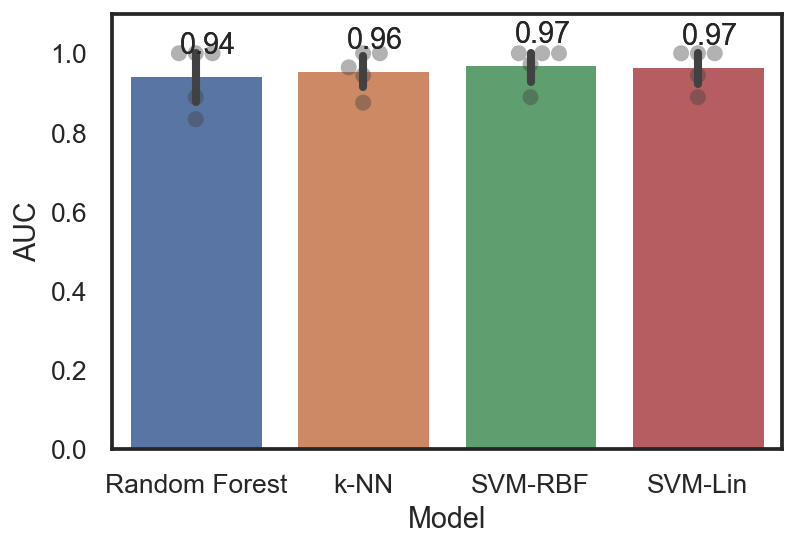

In [110]:
AUCfig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'SVM-Lin'], 
               'AUC':[mean(RF_AUC), mean(KNN_AUC), mean(clf_AUC), mean(linsvm_AUC)]}

afig = {'RF': RF_AUC, 'KNN': KNN_AUC, 'SVM': clf_AUC, 'Lin-SVM': linsvm_AUC}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(AUCfig, 'AUC');
#plt.title('ML Model AUC Comparison for RCC prediction');

In [111]:
# A function to print out all numeric (and summary of) results
def summary(name, result):
    print ('All Train result for', name, result)
    print ('Summary metric for', name, round(mean(result),2),'+/-', round(np.std(result),2))

In [112]:
summary('Random Forest', RF_AUC)
summary('k-NN', KNN_AUC)
summary('RBF SVM', clf_AUC)
summary('Linear SVM', linsvm_AUC)

All Train result for Random Forest [1.0, 1.0, 0.8333333333333334, 1.0, 0.888888888888889]
Summary metric for Random Forest 0.94 +/- 0.07
All Train result for k-NN [1.0, 0.9642857142857142, 0.8750000000000002, 0.9999999999999999, 0.9444444444444444]
Summary metric for k-NN 0.96 +/- 0.05
All Train result for RBF SVM [1.0, 1.0, 0.888888888888889, 1.0, 0.9722222222222223]
Summary metric for RBF SVM 0.97 +/- 0.04
All Train result for Linear SVM [1.0, 1.0, 0.888888888888889, 1.0, 0.9444444444444445]
Summary metric for Linear SVM 0.97 +/- 0.04


**Accuracy**

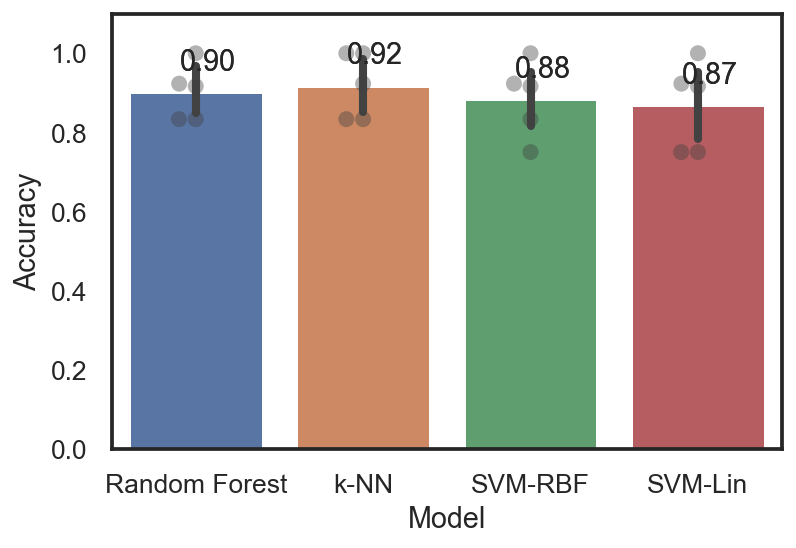

In [113]:
ACC_fig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'SVM-Lin'], 
               'Accuracy':[mean(RF_ACC), mean(KNN_ACC), mean(clf_ACC), mean(linsvm_ACC)]}

afig = {'RF': RF_ACC, 'KNN': KNN_ACC, 'SVM': clf_ACC, 'Lin-SVM': linsvm_ACC}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(ACC_fig, 'Accuracy');
#plt.title('ML Model Accuracy Comparison for RCC prediction');

In [114]:
summary('Random Forest', RF_ACC)
summary('k-NN', KNN_ACC)
summary('RBF SVM', clf_ACC)
summary('Linear SVM', linsvm_ACC)

All Train result for Random Forest [1.0, 0.9230769230769231, 0.8333333333333334, 0.9166666666666666, 0.8333333333333334]
Summary metric for Random Forest 0.9 +/- 0.06
All Train result for k-NN [1.0, 0.9230769230769231, 0.8333333333333334, 1.0, 0.8333333333333334]
Summary metric for k-NN 0.92 +/- 0.07
All Train result for RBF SVM [1.0, 0.9230769230769231, 0.8333333333333334, 0.9166666666666666, 0.75]
Summary metric for RBF SVM 0.88 +/- 0.09
All Train result for Linear SVM [1.0, 0.9230769230769231, 0.75, 0.9166666666666666, 0.75]
Summary metric for Linear SVM 0.87 +/- 0.1


**Precision**

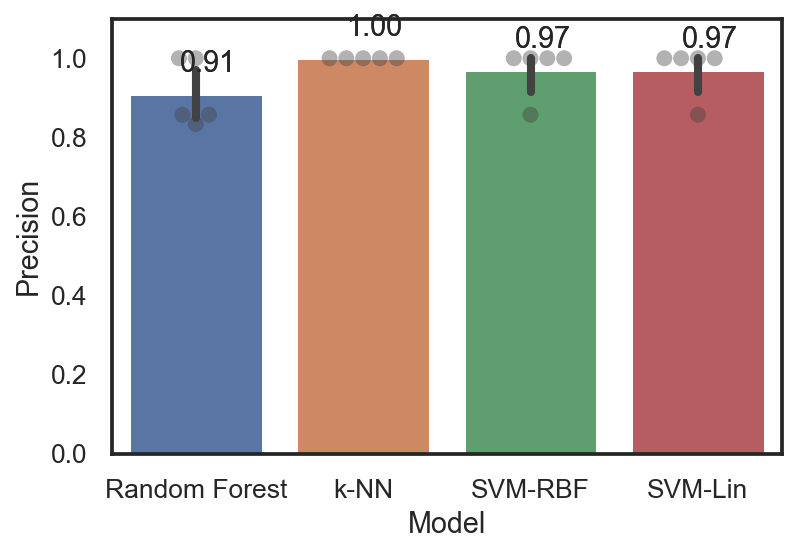

In [115]:
PREfig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'SVM-Lin'], 
               'Precision':[mean(RF_PRE), mean(KNN_PRE), mean(clf_PRE), mean(linsvm_PRE)]}

afig = {'RF': RF_PRE, 'KNN': KNN_PRE, 'SVM': clf_PRE, 'Lin-SVM': linsvm_PRE}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(PREfig, 'Precision');
#plt.title('ML Model Sensitivity (Precision) Comparison for RCC prediction');

**Recall**

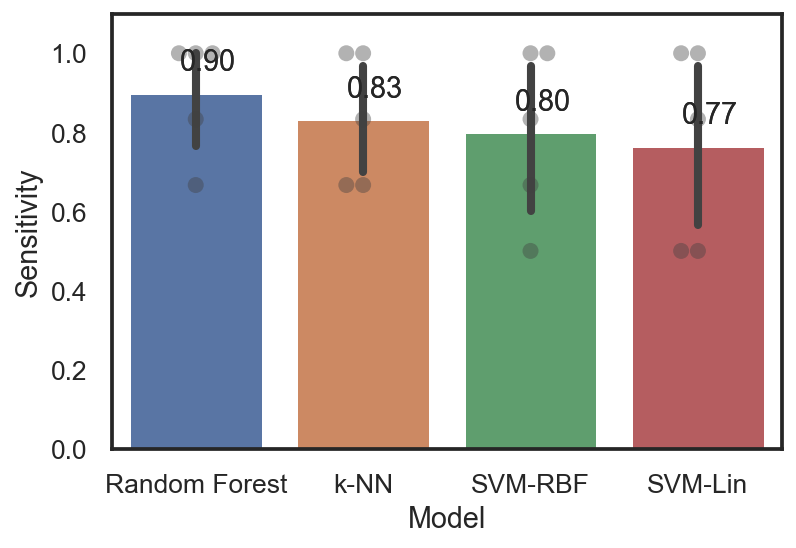

In [116]:
RECfig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'SVM-Lin'], 
               'Sensitivity':[mean(RF_REC), mean(KNN_REC), mean(clf_REC), mean(linsvm_REC)]}

afig = {'RF': RF_REC, 'KNN': KNN_REC, 'SVM': clf_REC, 'Lin-SVM': linsvm_REC}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(RECfig, 'Sensitivity');
#plt.title('ML Model Specificity (Recall) Comparison for RCC prediction');

In [117]:
summary('Random Forest', RF_REC)
summary('k-NN', KNN_REC)
summary('RBF SVM', clf_REC)
summary('Linear SVM', linsvm_REC)

All Train result for Random Forest [1.0, 1.0, 0.6666666666666666, 1.0, 0.8333333333333334]
Summary metric for Random Forest 0.9 +/- 0.13
All Train result for k-NN [1.0, 0.8333333333333334, 0.6666666666666666, 1.0, 0.6666666666666666]
Summary metric for k-NN 0.83 +/- 0.15
All Train result for RBF SVM [1.0, 0.8333333333333334, 0.6666666666666666, 1.0, 0.5]
Summary metric for RBF SVM 0.8 +/- 0.19
All Train result for Linear SVM [1.0, 0.8333333333333334, 0.5, 1.0, 0.5]
Summary metric for Linear SVM 0.77 +/- 0.23


**F1 Score**

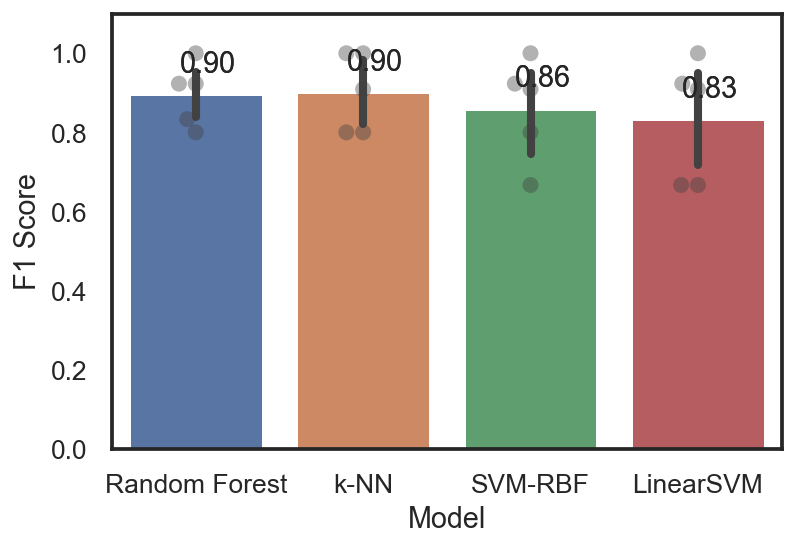

In [118]:
RECfig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'LinearSVM'], 
               'F1 Score':[mean(RF_FS), mean(KNN_FS), mean(clf_FS), mean(linsvm_FS)]}

afig = {'RF': RF_FS, 'KNN': KNN_FS, 'SVM': clf_FS, 'Lin-SVM': linsvm_FS}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(RECfig, 'F1 Score');
#plt.title('ML Model F1 Score Comparison for RCC prediction');

**Specificity**

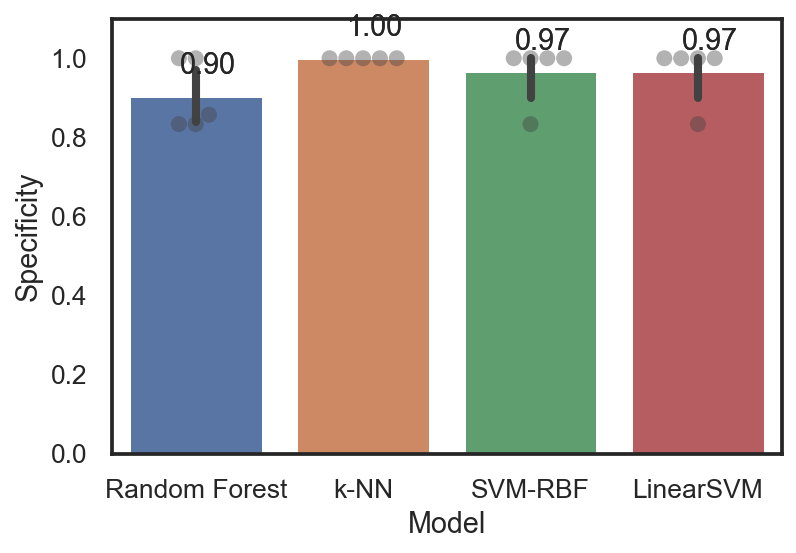

In [119]:
SPEfig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'LinearSVM'], 
               'Specificity':[mean(RF_SPE), mean(KNN_SPE), mean(clf_SPE), mean(linsvm_SPE)]}

afig = {'RF': RF_SPE, 'KNN': KNN_SPE, 'SVM': clf_SPE, 'Lin-SVM': linsvm_SPE}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(SPEfig, 'Specificity');
#plt.title('ML Model F1 Score Comparison for RCC prediction');

In [120]:
summary('Random Forest', RF_SPE)
summary('k-NN', KNN_SPE)
summary('RBF SVM', clf_SPE)
summary('Linear SVM', linsvm_SPE)

All Train result for Random Forest [1.0, 0.8571428571428571, 1.0, 0.8333333333333334, 0.8333333333333334]
Summary metric for Random Forest 0.9 +/- 0.08
All Train result for k-NN [1.0, 1.0, 1.0, 1.0, 1.0]
Summary metric for k-NN 1.0 +/- 0.0
All Train result for RBF SVM [1.0, 1.0, 1.0, 0.8333333333333334, 1.0]
Summary metric for RBF SVM 0.97 +/- 0.07
All Train result for Linear SVM [1.0, 1.0, 1.0, 0.8333333333333334, 1.0]
Summary metric for Linear SVM 0.97 +/- 0.07


### Chemical Information of the Biomarkers

In [121]:
# Import MS_labels
MS_labels = pd.read_excel('data/MS_labels.xlsx', index_col=0)

In [122]:
MS_labels[MS_labels.ID.isin(MLfeatures.columns)]

,ID,Mode,RT [min],Name,Formula


In [123]:
feature_imp = pd.Series(RF.feature_importances_,
                        index=MLfeatures.columns).sort_values(ascending=False)

No handles with labels found to put in legend.


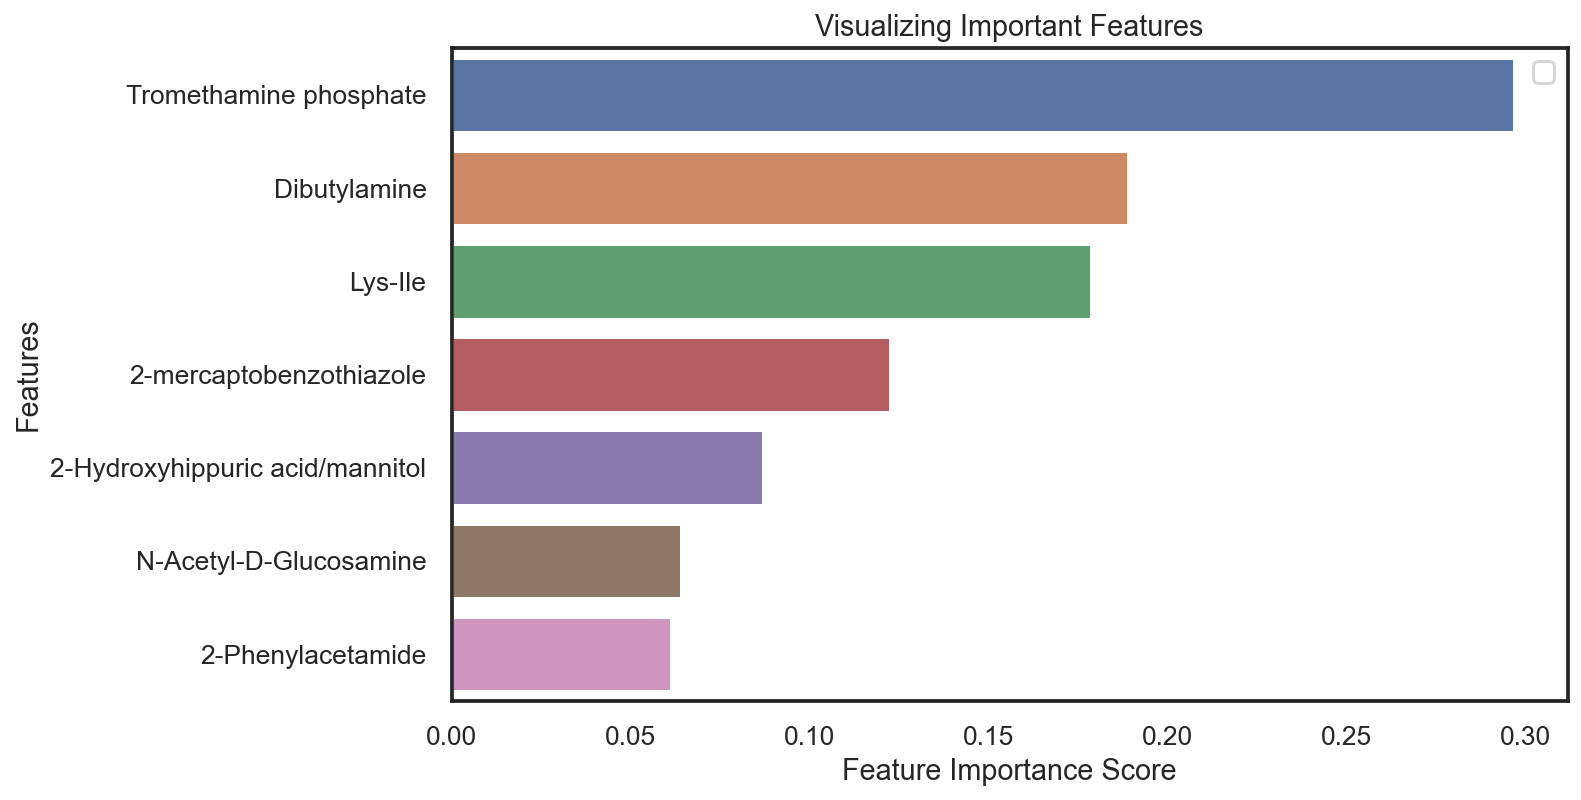

In [124]:
feature_imp = pd.Series(RF.feature_importances_,
                        index=MLfeatures.columns).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
#plt.savefig('RF_Features.svg', dpi=300)
plt.show()

### Potential Biomarkers: PCA, HCA, Boxplot Visualization

In [125]:
#biomarker_feat = dummydf[df_feat['Metabolites']]
#biomarker_feat =(biomarker_feat - biomarker_feat.mean(axis=0))/biomarker_feat.std(axis=0)
group_loc = modelcohort.columns.get_loc("Groups") #autoscaling
biomarker =  modelcohort.iloc[:, group_loc].to_frame().join(MLfeatures)

**p and q values associated with the metabolite panel in the model cohort**

In [126]:
stat_sig[stat_sig.Metabolite.isin(biomarker.columns)]

,Metabolite,T-test p-value,FDR p-value,Reject H0
815,Dibutylamine,7.480753e-08,0.000157,True
283,2-Phenylacetamide,1.466276e-06,0.000441,True
1881,2-Hydroxyhippuric acid/mannitol,3.088222e-06,0.000554,True
1354,Tromethamine phosphate,4.246283e-06,0.000558,True
593,Lys-Ile,4.260921e-05,0.001362,True
1993,2-mercaptobenzothiazole,8.784423e-04,0.009105,True
1996,N-Acetyl-D-Glucosamine,3.203173e-03,0.021601,True


**Boxplot**

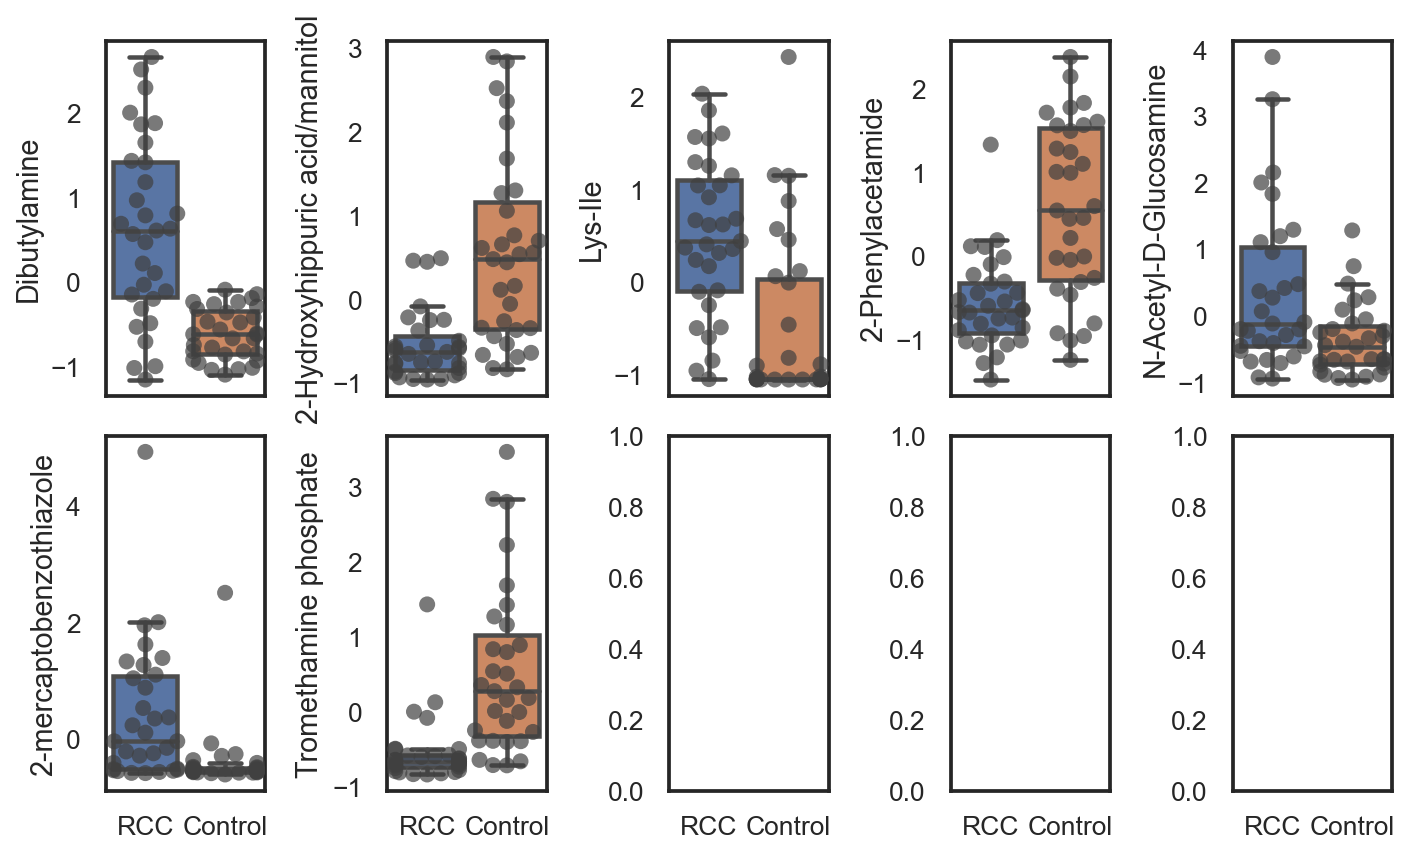

In [127]:
# Metabolites Quantification via boxplot or barplot
fig, axes = plt.subplots(nrows=2, ncols=5, sharex=True, figsize=(10, 6))
for idx, feat in enumerate(biomarker.columns[1:]):
    ax = axes[int(idx / 5), idx % 5]
    sns.boxplot(x='Groups', y=feat, data=biomarker, 
                ax=ax, showfliers=False)
    #sns.barplot (x='Groups', y=feat, data=df, ax=ax, capsize=.06)
    sns.swarmplot(x='Groups', y=feat, data=biomarker, 
                  ax=ax, s=8, alpha=0.7, color=".25");
    ax.set_xlabel('')
    ax.set_ylabel(feat) #feat
fig.tight_layout();
#plt.savefig('AUCplots.svg', dpi=300)

**PCA**

In [128]:
def PCA_Python(X, y, scaled=True):
    '''
    FUNCTION:  
    A principle component analysis function
    Note that number of component to be picked is fixed at 2 and scaling is pareto. 
    **Edit function to make this flexible** 
    
    DEPENDENCY: sklearn
    from sklearn import decomposition
    
    INPUT: Pandas dataframe
    X: Data. Numerical.
    y: Groups
    scaled: Boolean. Default=True
   
    
    OUTPUT: figure
    A PCA score plot
    
    '''
    pca = decomposition.PCA(n_components=2)
    if scaled == True: 
        X_centered = (X - X.mean(axis=0))/np.sqrt(X.std(axis=0)) # pareto scaling.
        #X_centered =(X - X.mean(axis=0))/X.std(axis=0) #autoscaling
    elif scaled == False:
        X_centered = X
    
    pca.fit(X_centered)
    X_pca = pca.transform(X_centered)
    Var = pca.explained_variance_ratio_ # returns variance ratio of the selected component. 
    a = plt.plot(X_pca[y == 0, 0], X_pca[y == 0, 1], 'bo', label='Control');
    b = plt.plot(X_pca[y == 1, 0], X_pca[y == 1, 1], 'ro', label='RCC');
    c = plt.xlabel("PC1: " + str(round(Var[0]*100, 2)) + "%");
    d = plt.ylabel("PC2: " + str(round(Var[1]*100, 2))+ "%");
    e = plt.legend(loc=0);
    return (a, b, c, d, e)

PCA score plots using all ML features

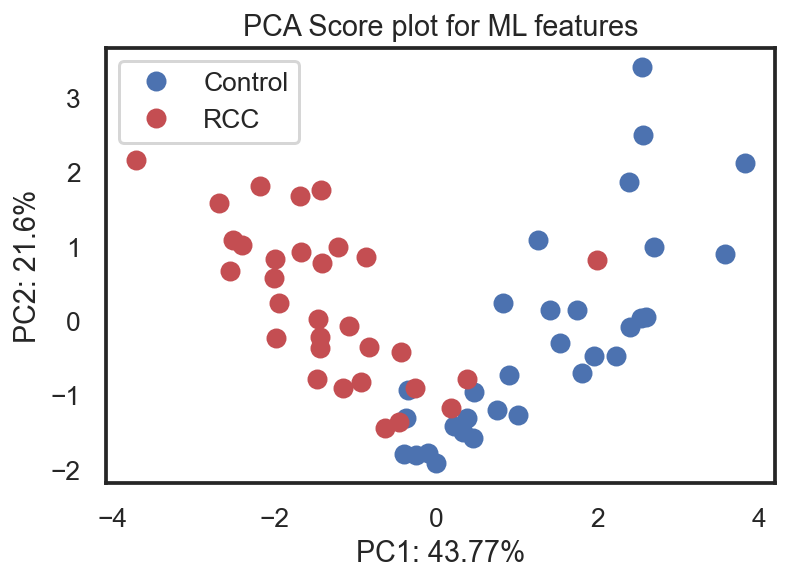

In [129]:
ylabel = biomarker['Groups'].map({'Control' : 0, 'RCC' : 1})
PCA_Python(MLfeatures, ylabel, False)
plt.title('PCA Score plot for ML features');

**Hierarchial Clustering using all ML features**

In [130]:
group_loc = modelcohort.columns.get_loc("Groups") #autoscaling
biomarker =  modelcohort.iloc[:, group_loc].to_frame().join(MLfeatures)

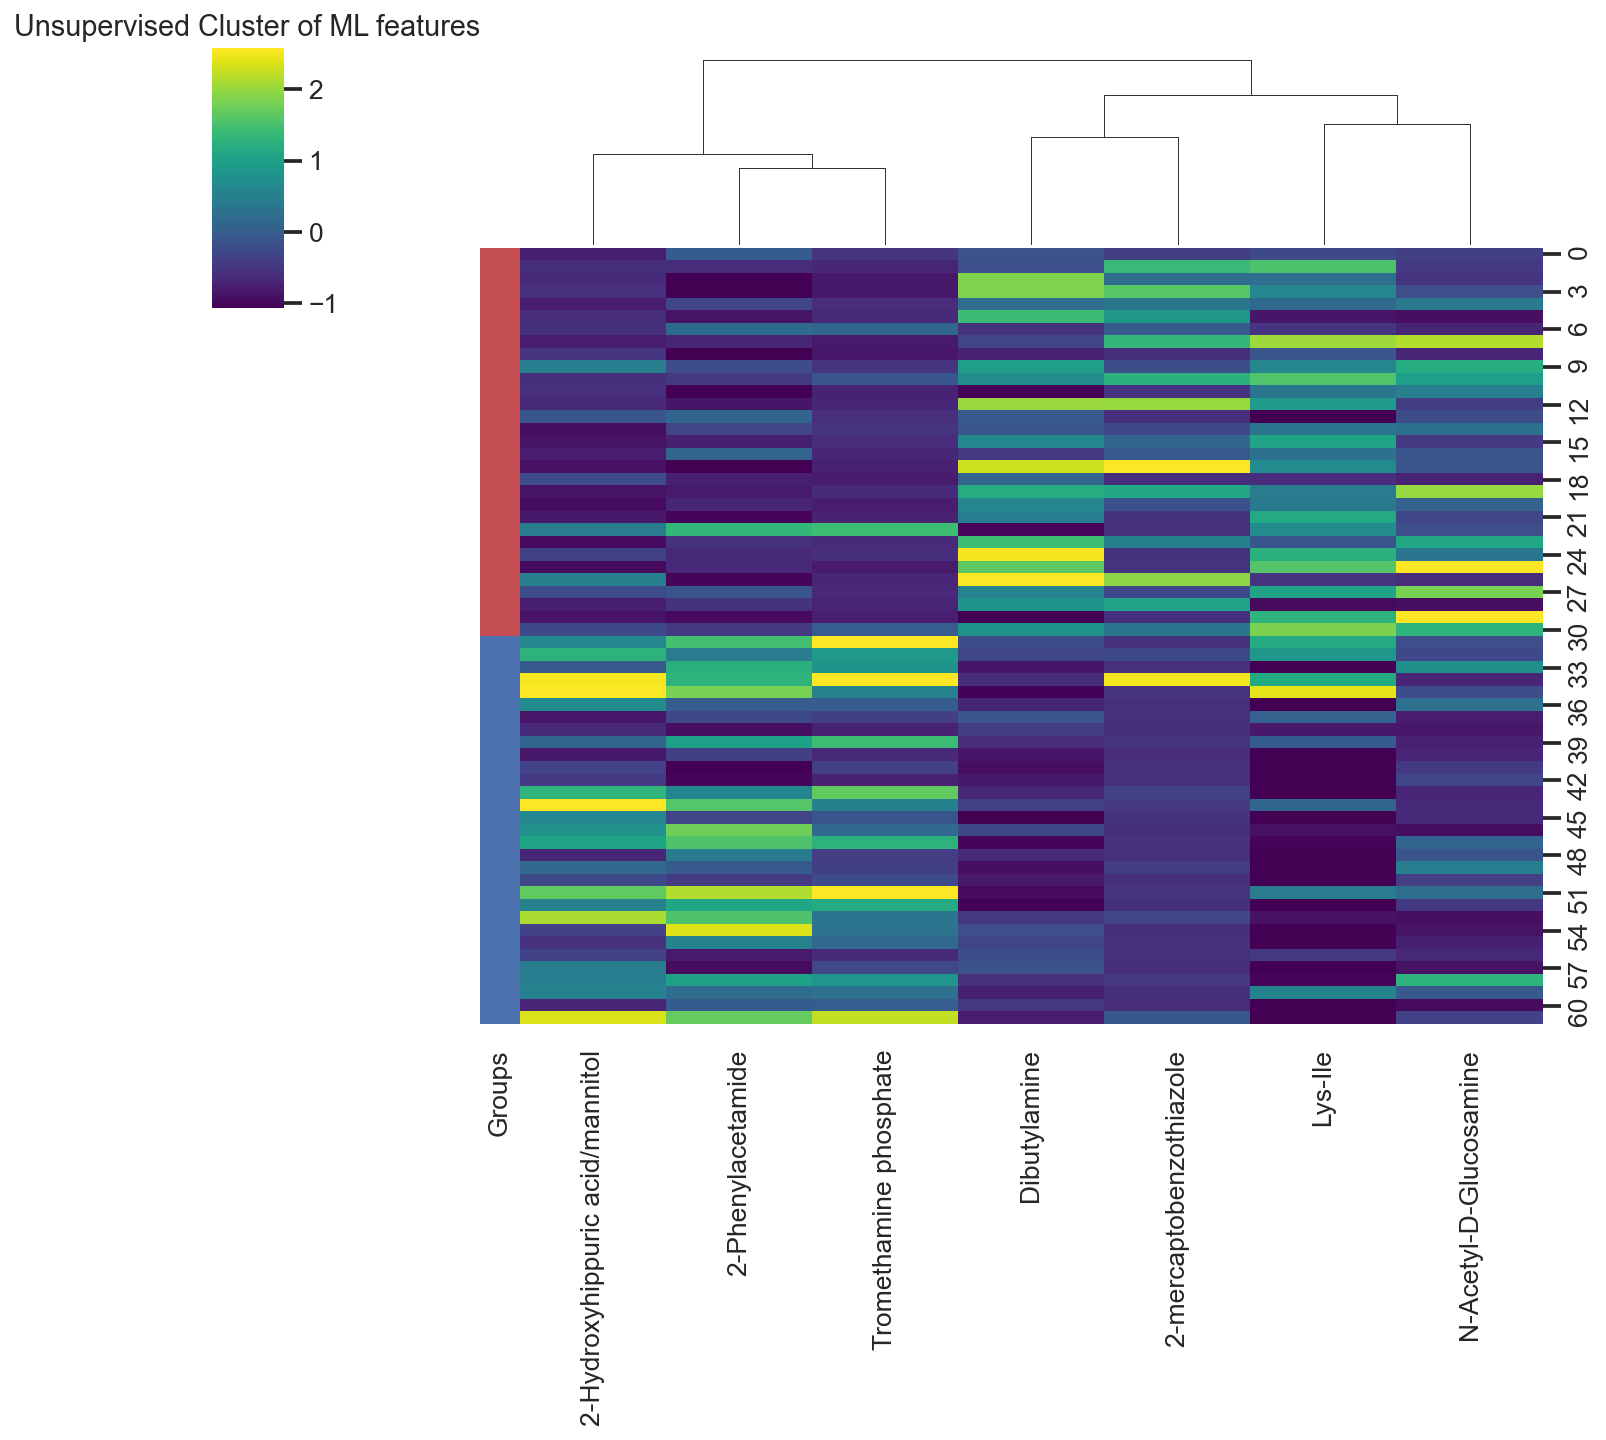

In [131]:
groups_two = biomarker.pop('Groups')
biomarker = biomarker.astype(float)
lut = dict(zip(groups_two.unique(), 'rbg'))
row_colors = groups_two.map(lut)
sns.clustermap(biomarker, method="weighted", 
                   metric='euclidean', cmap="viridis", row_cluster=False, 
                   row_colors=row_colors, robust=True);
plt.title('Unsupervised Cluster of ML features');
# define biomarker dataframe again because of the .pop method
biomarker =  modelcohort.iloc[:, group_loc].to_frame().join(MLfeatures)

**Hierarchial Clustering using features with _q_ value < 0.05**

In [132]:
Feature = stat_sig['Metabolite'].values.tolist(); # stat MS significant metabolites
qfeatures = NMRMS[Feature] # p<0.05 metabolites
qfeatures =(qfeatures - qfeatures.mean(axis=0))/qfeatures.std(axis=0) #autoscaling
group_loc = modelcohort.columns.get_loc("Groups") #autoscaling
qmarker = modelcohort.iloc[:, group_loc].to_frame().join(qfeatures)
print ('The total number of features in this DF is:', len(Feature))

The total number of features in this DF is: 435


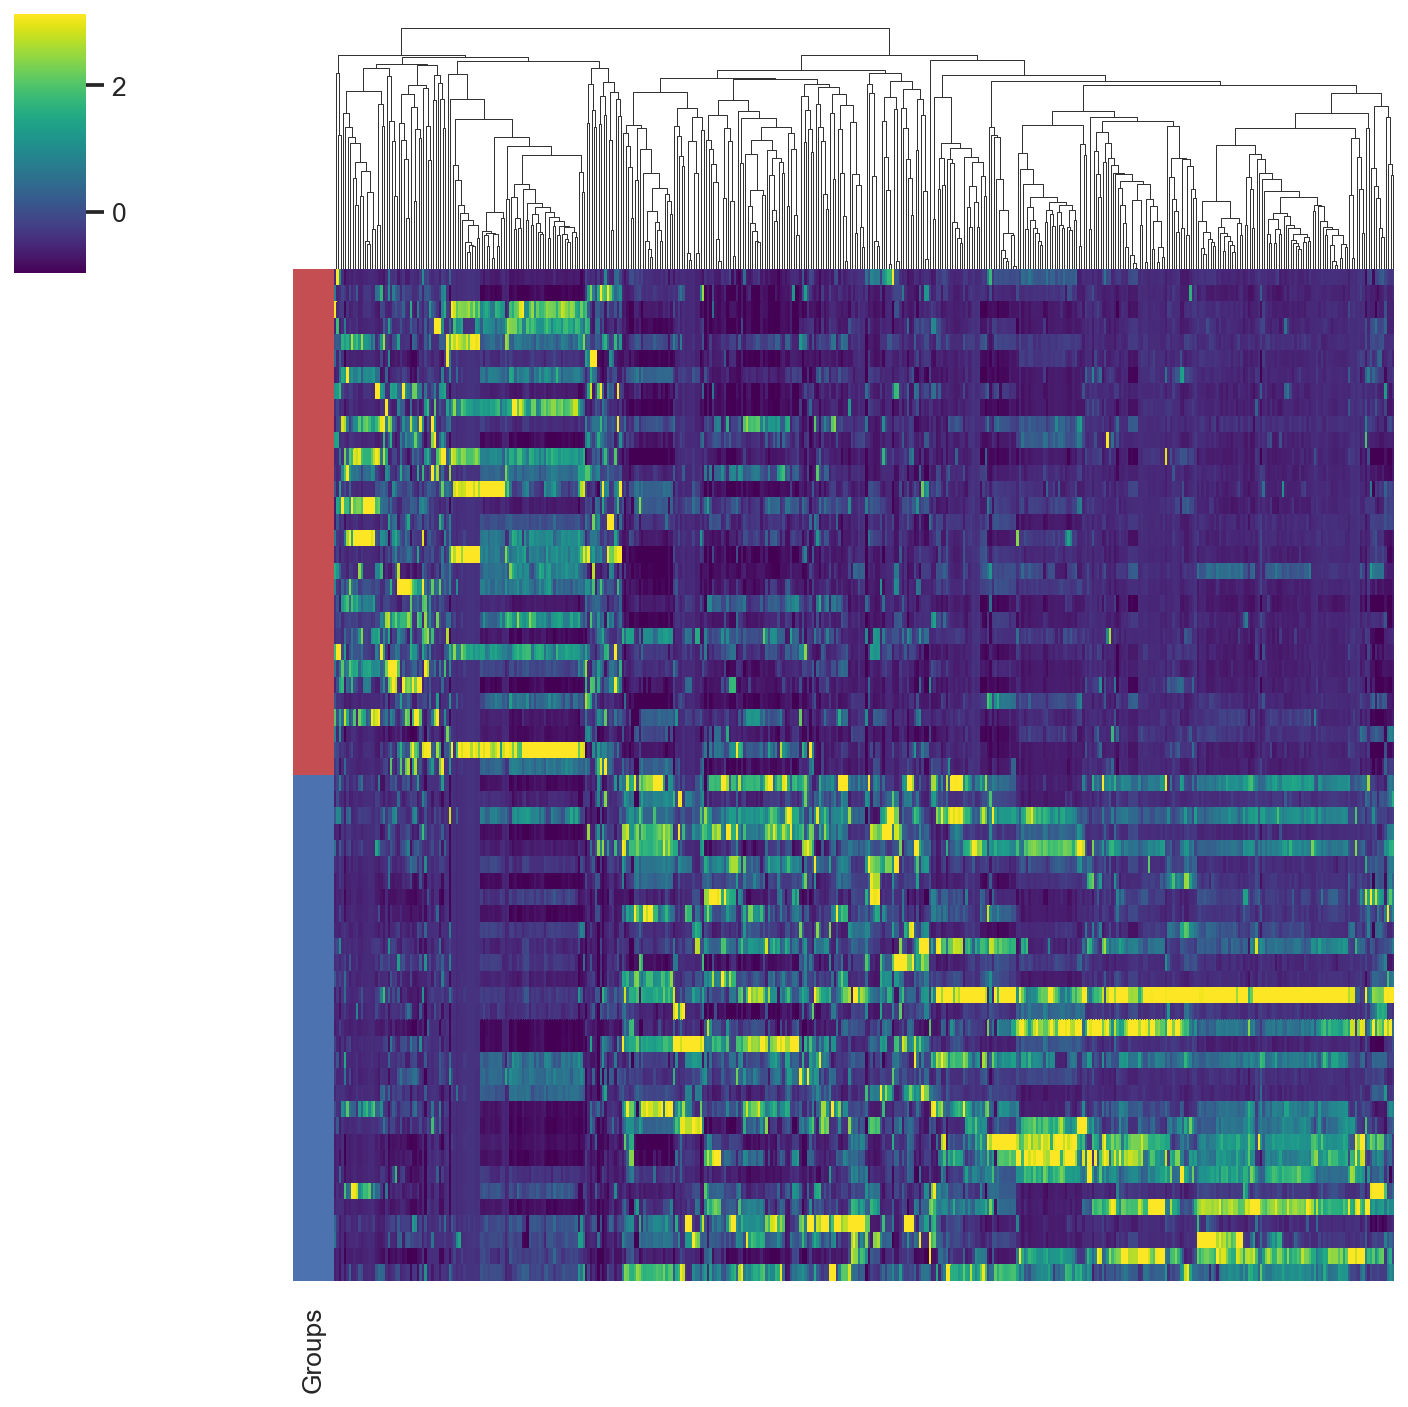

In [133]:
groups_two = qmarker.pop('Groups')
qmarker = qmarker.astype(float)
lut = dict(zip(groups_two.unique(), 'rbg'))
row_colors = groups_two.map(lut)
hca_qmarker = sns.clustermap(qmarker, method="weighted", 
               metric='euclidean', cmap="viridis", 
               row_cluster=False, row_colors=row_colors, 
               robust=True, xticklabels=False, 
               yticklabels=False);
#plt.title('Unsupervised Cluster of ML features');

#save figure
#hca_qmarker.savefig("hca_qmarker.svg")
# define biomarker dataframe again because of the .pop method
qmarker = modelcohort.iloc[:, group_loc].to_frame().join(qfeatures)

## 3. RCC Classification: Test Cohort
<a id="3"></a>

In [134]:
testcohort = pd.read_excel('data/testcohort.xlsx', index_col=0)

testcohort.rename(columns={720:'2-Phenylacetamide', 1481:'Lys-Ile', 
                      2102: 'Dibutylamine', 3804: 'Tromethamine phosphate', 
                      6262: '2-Hydroxyhippuric acid/mannitol', 6578: '2-mercaptobenzothiazole',
                      6594: 'N-Acetyl-D-Glucosamine'}, inplace=True)

MLfeatures2 = testcohort[biomarker.iloc[:, 1:].columns]
MLfeatures2 =(MLfeatures2 - MLfeatures2.mean(axis=0))/MLfeatures2.std(axis=0) #autoscaling
MLfeatures2.shape

(194, 7)

In [135]:
# define features and label.
dfgrp = testcohort.filter(['Groups'], axis=1)
#convert strings (RCC, Control) to integers
dfgroup = dfgrp['Groups'].map({'Control': 0, 'RCC': 1}) 
X = MLfeatures2.values
y = dfgroup.values
print (X.shape)
print (y.shape)

(194, 7)
(194,)


### Call the tuned machine learning algorithms

In [136]:
print(RF)
print(linsvm)
print(clf)
print(knn)

RandomForestClassifier(max_depth=10, min_samples_split=4, n_estimators=50,
                       random_state=42)
SVC(C=0.1, kernel='linear', probability=True, random_state=42)
SVC(C=1, gamma=0.03, probability=True, random_state=42)
KNeighborsClassifier(n_neighbors=7, p=1)


In [137]:
#RF=RandomForestClassifier(n_estimators=100, random_state=123)
metric = ml_model(X, y, RF)
RF_AUC, RF_ACC, RF_PRE, RF_REC, RF_FS, RF_MCC, RF_SPE = metric[0], metric[1], metric[2], metric[3], metric[4], metric[5], metric[6]

# Linear-SVM
metric = ml_model(X, y, linsvm)
linsvm_AUC, linsvm_ACC, linsvm_PRE, linsvm_REC, linsvm_FS, linsvm_MCC, linsvm_SPE = metric[0], metric[1], metric[2], metric[3], metric[4], metric[5], metric[6]

# SVM
#clf = svm.SVC(kernel='linear', probability=True)
metric = ml_model(X, y, clf)
clf_AUC, clf_ACC, clf_PRE, clf_REC, clf_FS, clf_MCC, clf_SPE = metric[0], metric[1], metric[2], metric[3], metric[4], metric[5], metric[6]

# KNN
metric = ml_model(X, y, knn)
KNN_AUC, KNN_ACC, KNN_PRE, KNN_REC, KNN_FS, KNN_MCC, KNN_SPE = metric[0], metric[1], metric[2], metric[3], metric[4], metric[5], metric[6]

**AUC**

In [138]:
sns.set_context('talk', font_scale=0.8)

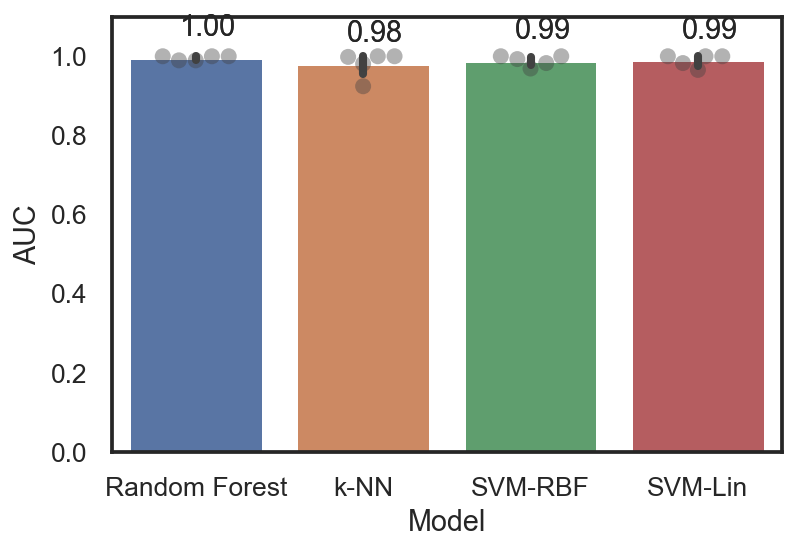

In [139]:
AUCfig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'SVM-Lin'], 
               'AUC':[mean(RF_AUC), mean(KNN_AUC), mean(clf_AUC), mean(linsvm_AUC)]}

afig = {'RF': RF_AUC, 'KNN': KNN_AUC, 'SVM': clf_AUC, 'Lin-SVM': linsvm_AUC}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(AUCfig, 'AUC');
#plt.title('ML Model AUC Comparison for RCC prediction');

In [140]:
summary('Random Forest', RF_AUC)
summary('k-NN', KNN_AUC)
summary('RBF SVM', clf_AUC)
summary('Linear SVM', linsvm_AUC)

All Train result for Random Forest [1.0, 0.9896551724137931, 1.0, 0.9896551724137931, 1.0]
Summary metric for Random Forest 1.0 +/- 0.01
All Train result for k-NN [0.9983766233766234, 0.9241379310344827, 1.0, 0.9810344827586206, 1.0]
Summary metric for k-NN 0.98 +/- 0.03
All Train result for RBF SVM [1.0, 0.9689655172413794, 1.0, 0.9827586206896551, 0.9928571428571429]
Summary metric for RBF SVM 0.99 +/- 0.01
All Train result for Linear SVM [1.0, 0.9655172413793104, 1.0, 0.9827586206896551, 1.0]
Summary metric for Linear SVM 0.99 +/- 0.01


**Accuracy**

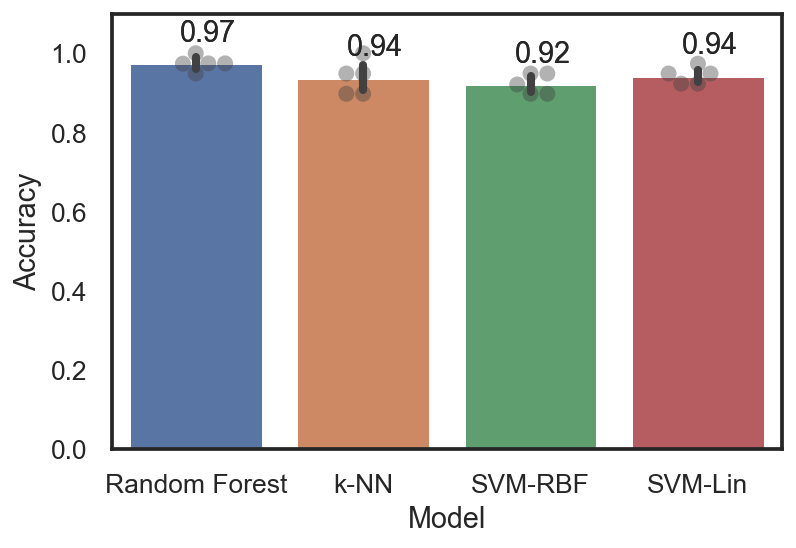

In [141]:
ACC_fig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'SVM-Lin'], 
               'Accuracy':[mean(RF_ACC), mean(KNN_ACC), mean(clf_ACC), mean(linsvm_ACC)]}

afig = {'RF': RF_ACC, 'KNN': KNN_ACC, 'SVM': clf_ACC, 'Lin-SVM': linsvm_ACC}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(ACC_fig, 'Accuracy');
#plt.title('ML Model Accuracy Comparison for RCC prediction');

In [142]:
summary('Random Forest', RF_ACC)
summary('k-NN', KNN_ACC)
summary('RBF SVM', clf_ACC)
summary('Linear SVM', linsvm_ACC)

All Train result for Random Forest [0.9743589743589743, 0.9487179487179487, 1.0, 0.9743589743589743, 0.9736842105263158]
Summary metric for Random Forest 0.97 +/- 0.02
All Train result for k-NN [0.9487179487179487, 0.8974358974358975, 0.9487179487179487, 0.8974358974358975, 1.0]
Summary metric for k-NN 0.94 +/- 0.04
All Train result for RBF SVM [0.9487179487179487, 0.8974358974358975, 0.8974358974358975, 0.9487179487179487, 0.9210526315789473]
Summary metric for RBF SVM 0.92 +/- 0.02
All Train result for Linear SVM [0.9487179487179487, 0.9230769230769231, 0.9230769230769231, 0.9487179487179487, 0.9736842105263158]
Summary metric for Linear SVM 0.94 +/- 0.02


**Precision**

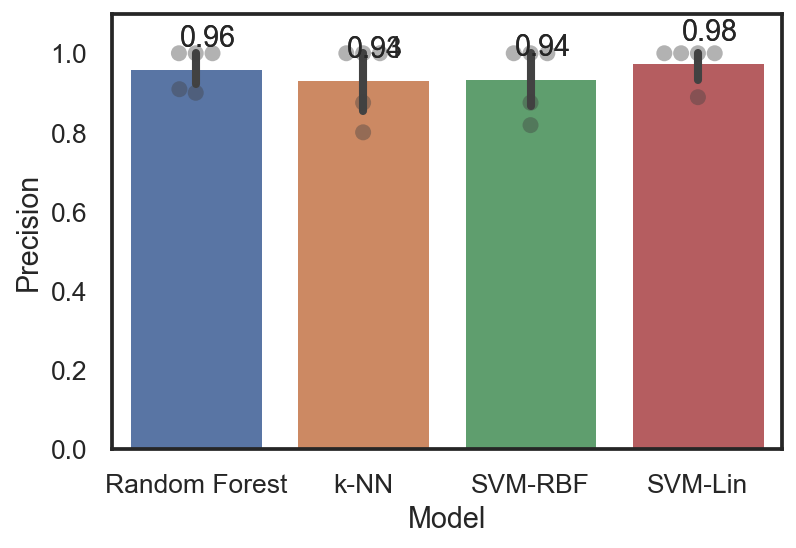

In [143]:
PREfig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'SVM-Lin'], 
               'Precision':[mean(RF_PRE), mean(KNN_PRE), mean(clf_PRE), mean(linsvm_PRE)]}

afig = {'RF': RF_PRE, 'KNN': KNN_PRE, 'SVM': clf_PRE, 'Lin-SVM': linsvm_PRE}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(PREfig, 'Precision');
#plt.title('ML Model Sensitivity (Precision) Comparison for RCC prediction');

**Recall**

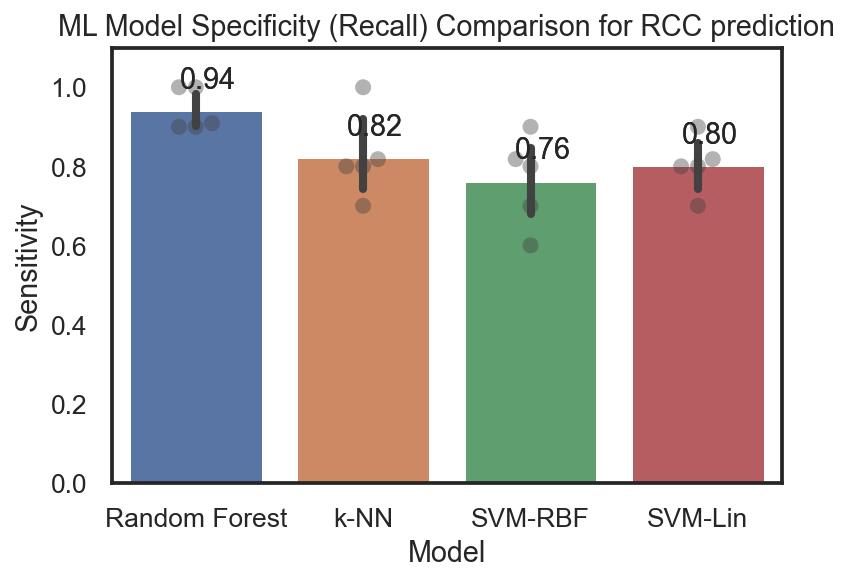

In [144]:
RECfig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'SVM-Lin'], 
               'Sensitivity':[mean(RF_REC), mean(KNN_REC), mean(clf_REC), mean(linsvm_REC)]}

afig = {'RF': RF_REC, 'KNN': KNN_REC, 'SVM': clf_REC, 'Lin-SVM': linsvm_REC}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(RECfig, 'Sensitivity');
plt.title('ML Model Specificity (Recall) Comparison for RCC prediction');

In [145]:
summary('Random Forest', RF_REC)
summary('k-NN', KNN_REC)
summary('RBF SVM', clf_REC)
summary('Linear SVM', linsvm_REC)

All Train result for Random Forest [0.9090909090909091, 0.9, 1.0, 0.9, 1.0]
Summary metric for Random Forest 0.94 +/- 0.05
All Train result for k-NN [0.8181818181818182, 0.7, 0.8, 0.8, 1.0]
Summary metric for k-NN 0.82 +/- 0.1
All Train result for RBF SVM [0.8181818181818182, 0.7, 0.6, 0.8, 0.9]
Summary metric for RBF SVM 0.76 +/- 0.1
All Train result for Linear SVM [0.8181818181818182, 0.8, 0.7, 0.8, 0.9]
Summary metric for Linear SVM 0.8 +/- 0.06


**F1 Score**

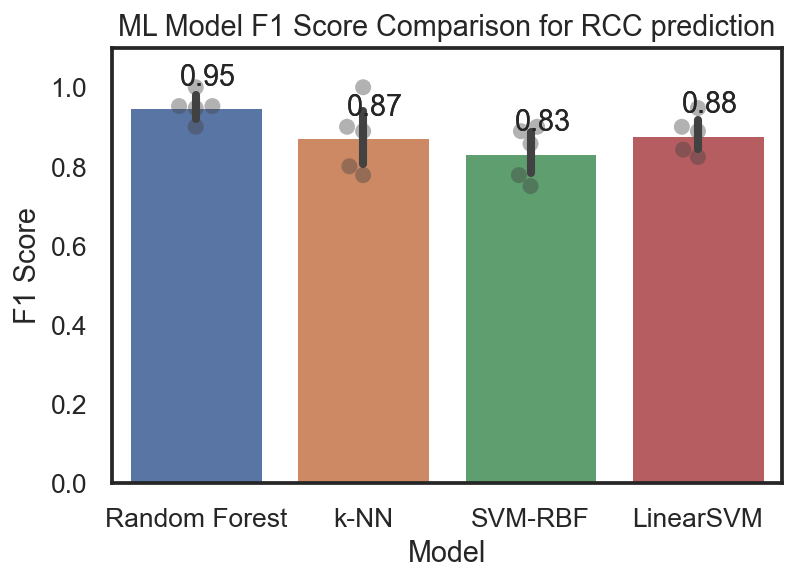

In [146]:
RECfig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'LinearSVM'], 
               'F1 Score':[mean(RF_FS), mean(KNN_FS), mean(clf_FS), mean(linsvm_FS)]}

afig = {'RF': RF_FS, 'KNN': KNN_FS, 'SVM': clf_FS, 'Lin-SVM': linsvm_FS}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(RECfig, 'F1 Score');
plt.title('ML Model F1 Score Comparison for RCC prediction');

**Specificity**

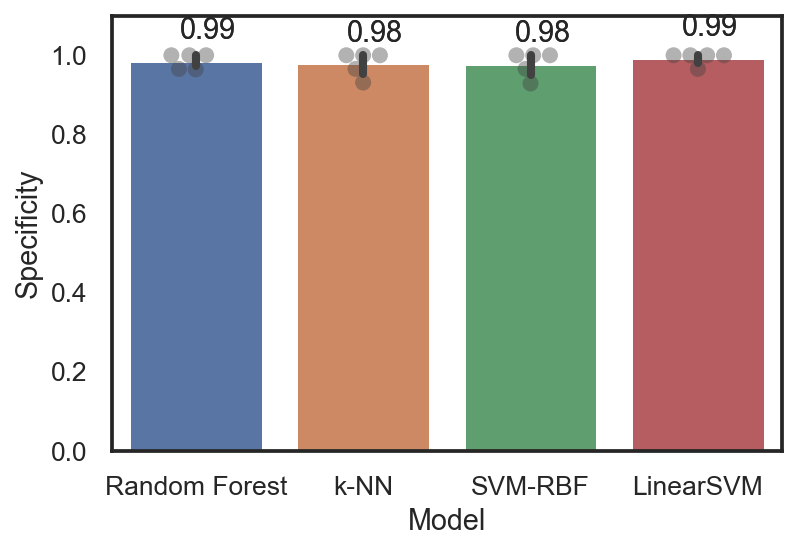

In [147]:
SPEfig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'LinearSVM'], 
               'Specificity':[mean(RF_SPE), mean(KNN_SPE), mean(clf_SPE), mean(linsvm_SPE)]}

afig = {'RF': RF_SPE, 'KNN': KNN_SPE, 'SVM': clf_SPE, 'Lin-SVM': linsvm_SPE}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(SPEfig, 'Specificity');
#plt.title('ML Model F1 Score Comparison for RCC prediction');

In [148]:
summary('Random Forest', RF_SPE)
summary('k-NN', KNN_SPE)
summary('RBF SVM', clf_SPE)
summary('Linear SVM', linsvm_SPE)

All Train result for Random Forest [1.0, 0.9655172413793104, 1.0, 1.0, 0.9642857142857143]
Summary metric for Random Forest 0.99 +/- 0.02
All Train result for k-NN [1.0, 0.9655172413793104, 1.0, 0.9310344827586207, 1.0]
Summary metric for k-NN 0.98 +/- 0.03
All Train result for RBF SVM [1.0, 0.9655172413793104, 1.0, 1.0, 0.9285714285714286]
Summary metric for RBF SVM 0.98 +/- 0.03
All Train result for Linear SVM [1.0, 0.9655172413793104, 1.0, 1.0, 1.0]
Summary metric for Linear SVM 0.99 +/- 0.01


One of the best classifier is RF, and here are the feature importance from random forest:

No handles with labels found to put in legend.


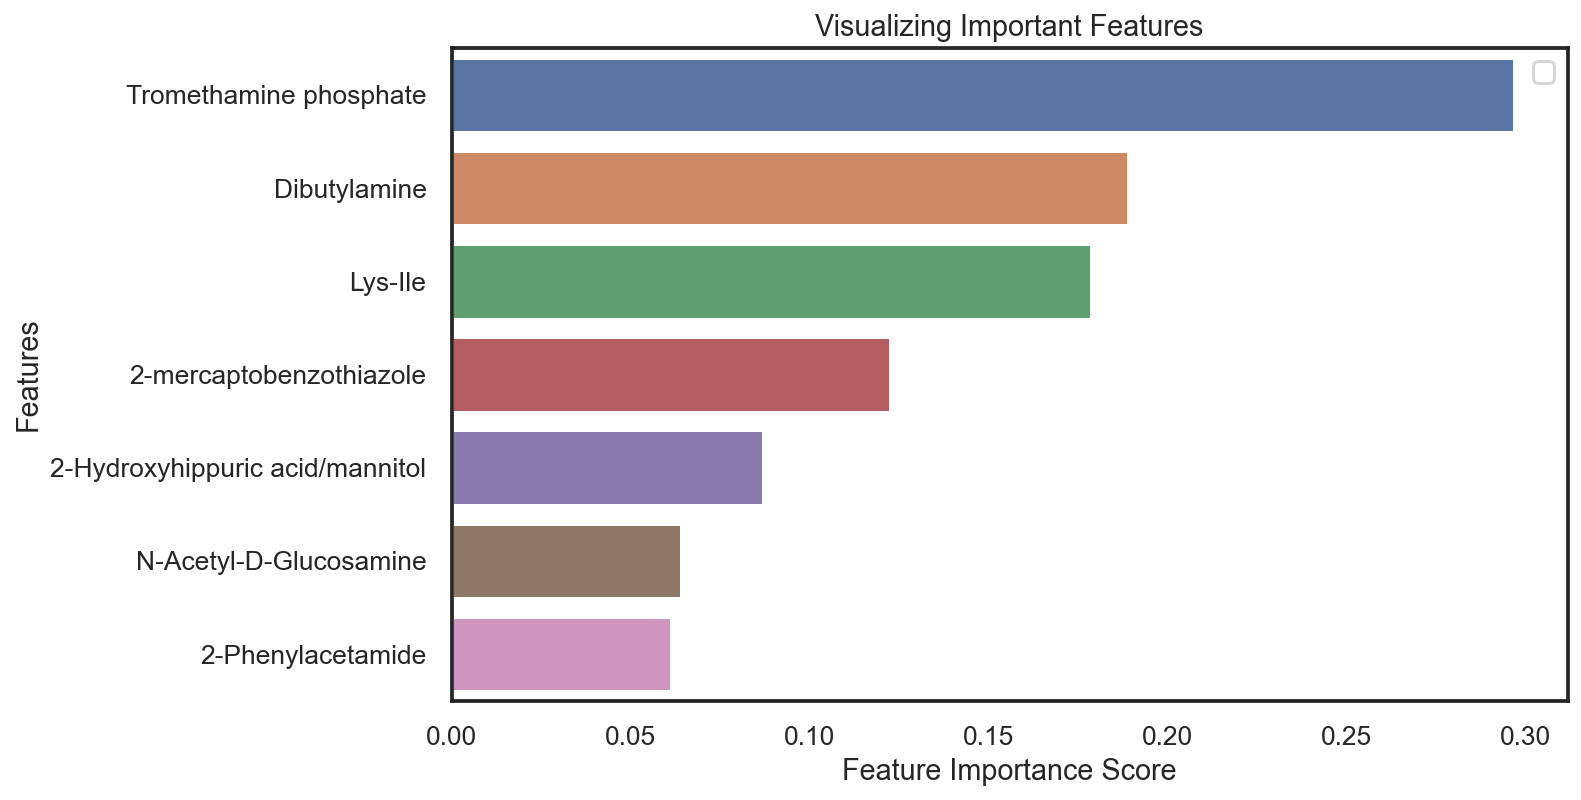

In [149]:
plt.figure(figsize=(10,6))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
#plt.savefig('RF_Features.svg', dpi=300)
plt.show()

### Biomarkers: PCA, Hierarchical clustering and Boxplot Visualization

In [150]:
print (testcohort.shape)
print (MLfeatures2.shape)

(194, 7155)
(194, 7)


In [151]:
group_loc = testcohort.columns.get_loc("Groups") #autoscaling
biomarker2 =  testcohort.iloc[:, group_loc].to_frame().join(MLfeatures2)
biomarker2.shape

(194, 8)

**_T_-test for metabolic features in the test cohort**

In [152]:
# Select the metabolic feature panel for RCC
MLfeatures2 = testcohort[biomarker.iloc[:, 1:].columns]
# Get the 'group' location
group_loc = testcohort.columns.get_loc("Groups") 
# Join group with the metabolic feature panel for RCC
biomarker_TC =  testcohort.iloc[:, group_loc].to_frame().join(MLfeatures2)
# Build biomarker dataframe for Controls and RCC
Control_TC = biomarker_TC[(biomarker_TC['Groups'] == 'Control')]
RCC_TC = biomarker_TC[(biomarker_TC['Groups'] == 'RCC')]
# drop groups from the biomarker_TC columns
biomarker_TC.drop(['Groups'], axis=1, inplace=True)

In [153]:
ttest_result2 = Ttest(biomarker_TC.columns, Control_TC, 
                      RCC_TC, alpha=0.05, var=False)
ttest_result2

,Metabolite,T-test p-value,FDR p-value,Reject H0
3,2-Phenylacetamide,6.107402e-18,4.275181e-17,True
0,Dibutylamine,6.805514e-11,2.381930e-10,True
1,2-Hydroxyhippuric acid/mannitol,1.956155e-10,4.564363e-10,True
6,Tromethamine phosphate,2.783971e-09,4.871949e-09,True
2,Lys-Ile,3.639234e-07,5.094927e-07,True
4,N-Acetyl-D-Glucosamine,3.604872e-04,4.205684e-04,True
5,2-mercaptobenzothiazole,1.035021e-03,1.035021e-03,True


Boxplot

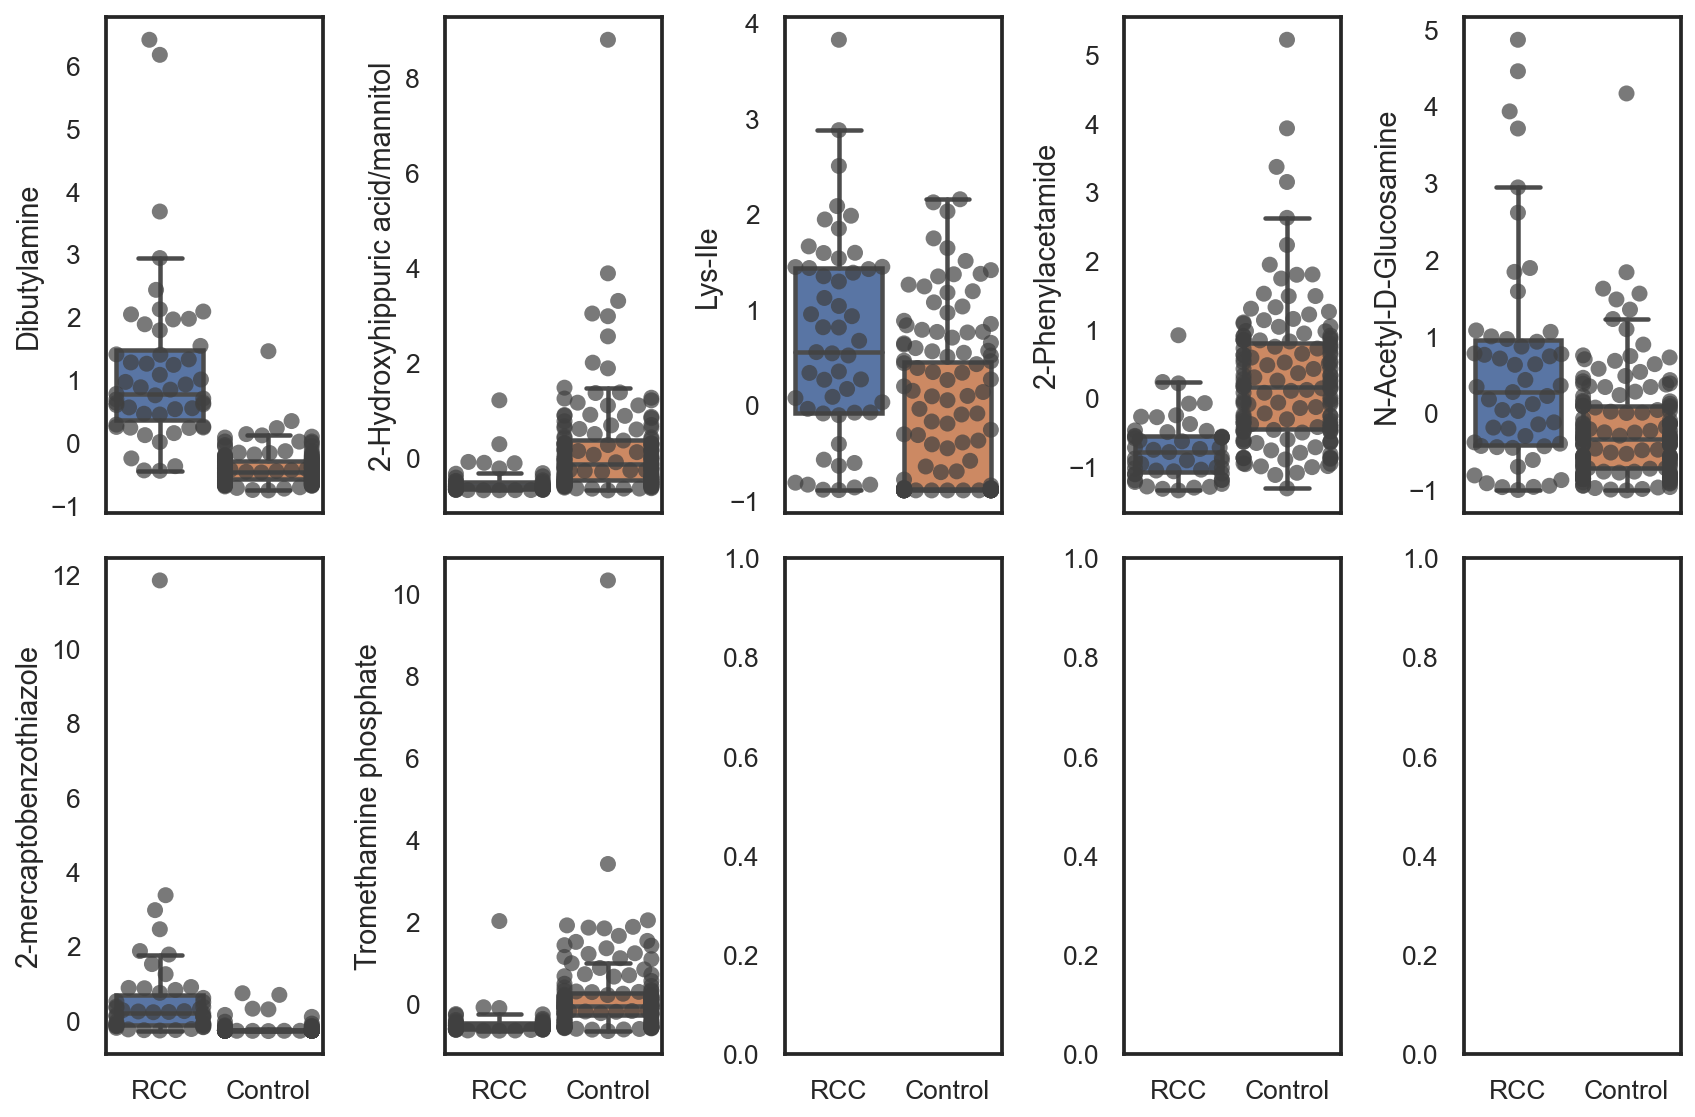

In [154]:
# Metabolites Quantification via boxplot or barplot
fig, axes = plt.subplots(nrows=2, ncols=5, sharex=True, figsize=(12, 8))
for idx, feat in enumerate(biomarker2.columns[1:]):
    ax = axes[int(idx / 5), idx % 5]
    sns.boxplot(x='Groups', y=feat, data=biomarker2, ax=ax, showfliers=False)
    #sns.barplot (x='Groups', y=feat, data=df, ax=ax, capsize=.06)
    sns.swarmplot(x='Groups', y=feat, data=biomarker2, 
                  ax=ax, s=8, alpha=0.7, color=".25");
    ax.set_xlabel('')
    ax.set_ylabel(feat) #feat
fig.tight_layout();
#plt.savefig('AUCplots2.svg', dpi=300)

**PCA score plots using all ML features**

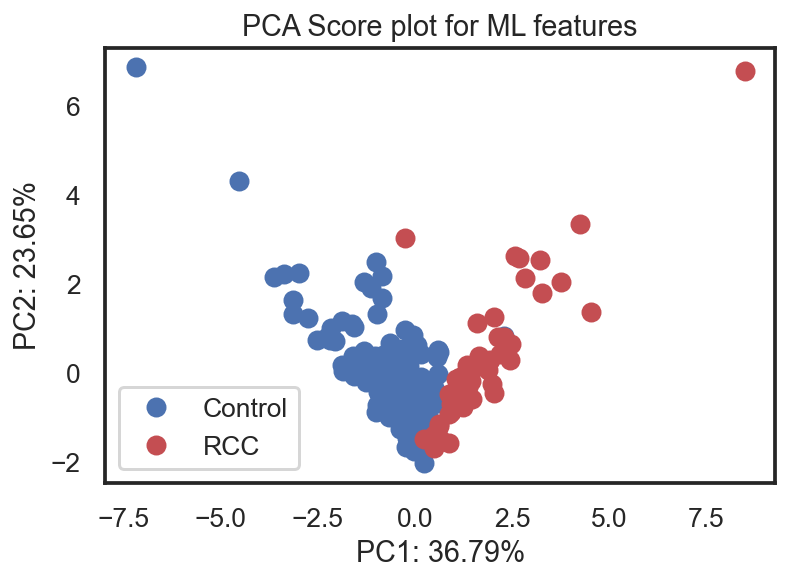

In [155]:
ylabel = biomarker2['Groups'].map({'Control' : 0, 'RCC' : 1})
MLfeatures2 =(MLfeatures2 - MLfeatures2.mean(axis=0))/MLfeatures2.std(axis=0) #autoscaling
PCA_Python(MLfeatures2, ylabel, False)
plt.title('PCA Score plot for ML features');

**Hierarchial Clustering using all ML features**

In [156]:
group_loc = testcohort.columns.get_loc("Groups") #autoscaling
biomarker2 =  testcohort.iloc[:, group_loc].to_frame().join(MLfeatures2)
biomarker2.shape

(194, 8)

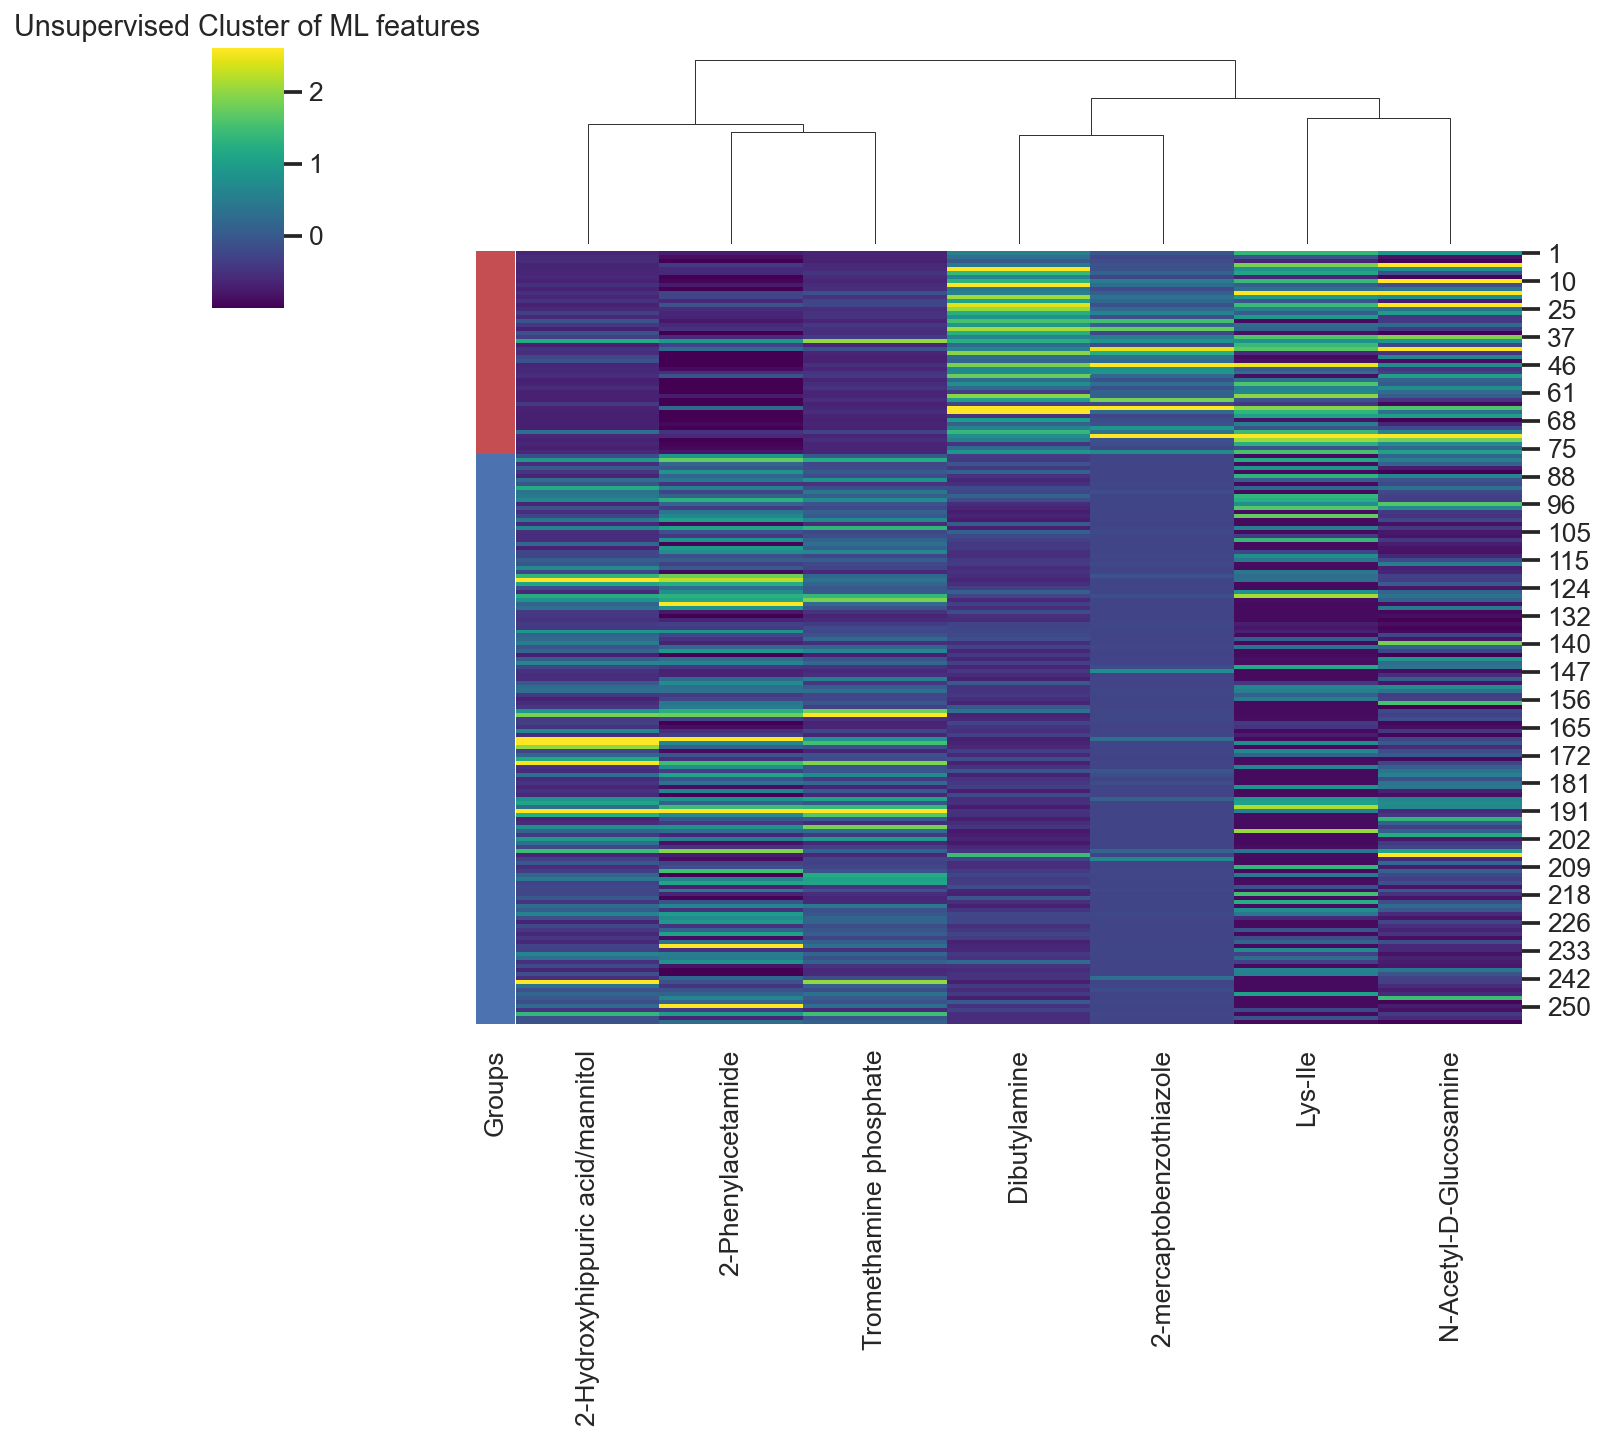

In [157]:
groups_two = biomarker2.pop('Groups')
biomarker2 = biomarker2.astype(float)
lut = dict(zip(groups_two.unique(), 'rbg'))
row_colors = groups_two.map(lut)
sns.clustermap(biomarker2, method="weighted", 
                   metric='euclidean', cmap="viridis", row_cluster=False, 
                   row_colors=row_colors, robust=True);
plt.title('Unsupervised Cluster of ML features');
# define biomarker dataframe again because of the .pop method
biomarker2 =  testcohort.iloc[:, group_loc].to_frame().join(MLfeatures2)